<a href="https://colab.research.google.com/github/panaitealexandra/PMP-2024/blob/main/Homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 6 - laborator 7
## Inferență Bayesiană cu PyMC

Un site web dorește să prezică rata zilnică p a utilizatorilor care finalizează o achiziție. Se observă date zilnice privind
numărul k de utilizatori care finalizează achiziția și numărul total n de vizitatori zilnici (astfel, p = k/n), timp de o
săptămână.

Observațiile sunt:

· Ziua 1: k = 10, n = 100;

· Ziua 2: k = 15, n = 120;

· Ziua 3: k = 20, n = 150;

· Ziua 4: k = 5, n = 90;

· Ziua 5: k = 25, n = 200;

· Ziua 6: k = 12, n = 110;

· Ziua 7: k = 18, n = 130.

Dorim să estimăm rata pentru fiecare zi a săptămânii, dar și rata medie. Presupunem că:

· rata zilnică p urmează o distribuție Beta(a = 2, ß = 2), care reflectă o preferință ușoară pentru valori apropiate
de 0.5, iar

· pentru fiecare zi, numărul de utilizatori care finalizează achiziția k¡ este modelat ca o variabilă binomială:

kj ~ Binomial(ni,Pi),
unde n; este numărul total de utilizatori în ziua i.

a) Definiți un model în PyMC care sa descrie contextul de mai sus.

b) Estimați distribuția a posteriori pentru fiecare pi, dar și pentru rata medie globală pmean = -(p1 + ... +p7).




## Ex. 2.
Valorile de trafic (masini/min.) înregistrate de o camera in jurul unei anumite intersectii din oraş, într-o zi normală,
sunt redate în fișierul trafic.scv (in fiecare minut, de la ora 4:00 până la 24:00). Presupunem că valorile respective sunt
determinate de o distribuție Poisson de parametru necunoscut A > 0. Se știe că modificări ale mediei traficului au loc în
jurul orelor 7, 16 (creştere) și 8, 19 (descreștere).

a) Definiți un model probabilist care sa descrie contextul de mai sus, folosind PyMC.

b) Determinați capetele cele mai probabile ale celor 5 intervale de timp, cât și cele mai probabile valori ale parametru-
lui A în acele intervale.

Output()

Output()

Output()

Output()


Estimated traffic rates (cars/minute) for each interval:
Interval 1 (4:00-7:00): 12.17 ± 0.26
Interval 2 (7:00-8:00): 17.18 ± 0.53
Interval 3 (8:00-16:00): 13.14 ± 0.16
Interval 4 (16:00-19:00): 14.60 ± 0.29
Interval 5 (19:00-24:00): 10.16 ± 0.18


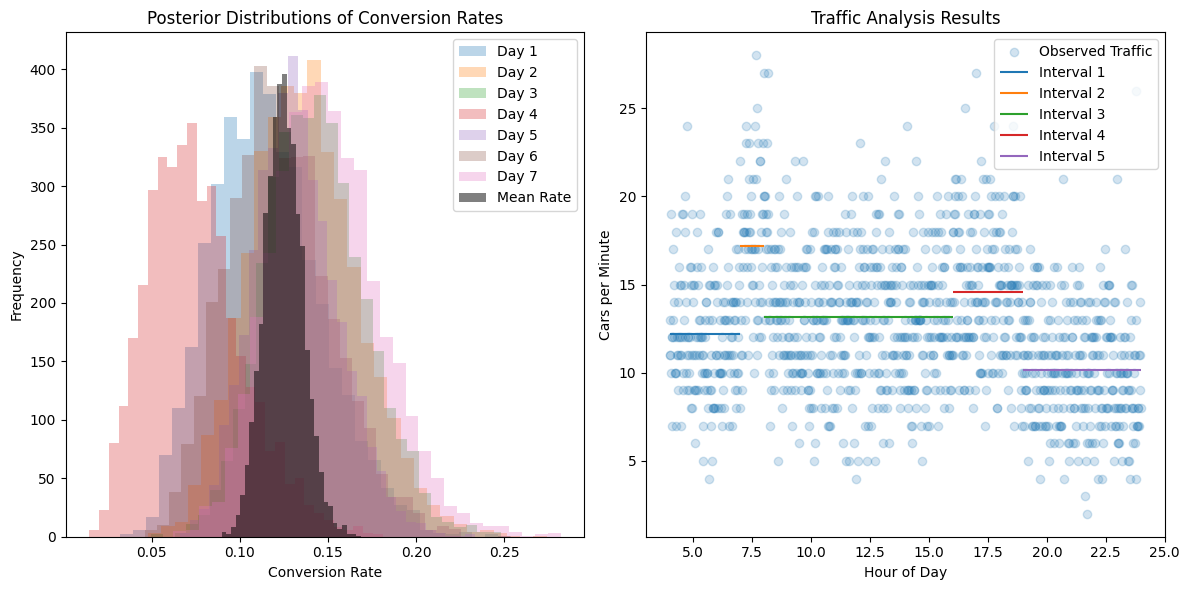

In [6]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exercise 1: Website Conversion Rate Analysis
def analyze_conversion_rates():
    # Data
    conversions = np.array([10, 15, 20, 5, 25, 12, 18])
    total_visitors = np.array([100, 120, 150, 90, 200, 110, 130])

    # Create PyMC model
    with pm.Model() as conversion_model:
        # Prior for daily conversion rates (Beta distribution)
        p = pm.Beta('p', alpha=2, beta=2, shape=7)

        # Likelihood (Binomial distribution)
        obs = pm.Binomial('obs', n=total_visitors, p=p, observed=conversions)

        # Calculate mean conversion rate
        pmean = pm.Deterministic('pmean', p.mean())

        # Sample from posterior
        trace = pm.sample(2000, return_inferencedata=False)

    return trace

# Exercise 2: Traffic Analysis
def analyze_traffic_data(data_file='trafic.csv'):
    # Read and prepare data
    df = pd.read_csv(data_file)
    cars = df['nr. masini'].values

    # Convert minutes to hours
    hours = (df['minut'].values - 1) / 60 + 4

    # Create interval indices
    intervals = np.zeros(len(hours), dtype=int)
    intervals[(hours >= 7) & (hours < 8)] = 1
    intervals[(hours >= 8) & (hours < 16)] = 2
    intervals[(hours >= 16) & (hours < 19)] = 3
    intervals[hours >= 19] = 4

    with pm.Model() as traffic_model:
        # Prior for Poisson rates in each interval
        lambda_intervals = pm.Gamma('lambda', alpha=2, beta=0.5, shape=5)

        # Likelihood using the interval indices
        obs = pm.Poisson('obs', mu=lambda_intervals[intervals], observed=cars)

        # Sample from posterior
        trace = pm.sample(2000, return_inferencedata=False)

    return trace, hours, cars

# Run analyses and plot results
def plot_results():
    # Exercise 1 Results
    trace1 = analyze_conversion_rates()

    plt.figure(figsize=(12, 6))

    # Plot Exercise 1 results
    plt.subplot(1, 2, 1)
    for i in range(7):
        plt.hist(trace1['p'][:, i], alpha=0.3, bins=30, label=f'Day {i+1}')
    plt.hist(trace1['pmean'], alpha=0.5, bins=30, label='Mean Rate', color='black')
    plt.title('Posterior Distributions of Conversion Rates')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Frequency')
    plt.legend()

    # Exercise 2 Results
    trace2, hours, cars = analyze_traffic_data()

    plt.subplot(1, 2, 2)
    plt.scatter(hours, cars, alpha=0.2, label='Observed Traffic')

    # Plot estimated rates
    change_points = [4, 7, 8, 16, 19, 24]

    for i in range(5):
        mean_rate = trace2['lambda'].mean(axis=0)[i]
        plt.hlines(y=mean_rate,
                  xmin=change_points[i],
                  xmax=change_points[i+1],
                  color=f'C{i}',
                  label=f'Interval {i+1}')

    plt.title('Traffic Analysis Results')
    plt.xlabel('Hour of Day')
    plt.ylabel('Cars per Minute')
    plt.legend()

    # Print the estimated rates for each interval
    print("\nEstimated traffic rates (cars/minute) for each interval:")
    for i in range(5):
        mean_rate = trace2['lambda'].mean(axis=0)[i]
        std_rate = trace2['lambda'].std(axis=0)[i]
        print(f"Interval {i+1} ({change_points[i]}:00-{change_points[i+1]}:00): {mean_rate:.2f} ± {std_rate:.2f}")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_results()